# Superbru stats: 2023/24 season

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import specific_data as sd

### Import and format data

In [169]:
# These are the columns for the data imported from superbru about individual players
match_col_dtypes = {'Round': 'int',
                    'Home team': 'category',
                    'Away team': 'category',
                    'Home goals': 'int',
                    'Away goals': 'int',
                    'Home prediction': 'int',
                    'Away prediction': 'int',
                    'Player score': 'category'}

round_col_dtypes = {'Round': 'int',
                    'Slam point': 'int',
                    'Round points': 'float'}

# Dictionaries which store dataframs of players' performaces
df_collection = {}
df_round_collection = {}
for person in sd.players:
    df_person = pd.read_csv(sd.csv_save_path + person + '_scores.csv', dtype=match_col_dtypes)
    df_round = pd.read_csv(sd.csv_save_path + person + '_rounds.csv', dtype=round_col_dtypes)
    df_collection[person] = df_person
    df_round_collection[person] = df_round


match_cols = ['Round', 'Home team', 'Away team', 'Home goals', 'Away goals']
df_match_results = df_collection[sd.players[0]][match_cols]
df_predictions = df_match_results

for person, df in df_collection.items():
    df_predictions = df_predictions.merge(df, on=match_cols, suffixes=(None, '_'+person), validate='one_to_one')

points_map = {'0NoPick': 0.0, '0WRONG': 0.0, '1.5CLOSE': 1.5, '1RESULT': 1.0, '3EXACT': 3.0, 'Postponed': 0.0}

# Since 'suffixes' does not force a suffix on the first instance, I treat the first player separately

df_predictions[sd.players[0].capitalize() + ' points'] = df_predictions['Player score'].replace(points_map).astype(float)
for person in sd.players[1:]:
    df_predictions[person.capitalize() + ' points'] = df_predictions['Player score_'+person].replace(points_map).astype(float)

points_per_round = df_predictions.groupby('Round')[[ps.capitalize() + ' points' for ps in sd.players]].sum()

print(df_predictions)




     Round     Home team     Away team  Home goals  Away goals  \
0        1        Celtic   Ross County           4           2   
1        1        Dundee    Motherwell           1           1   
2        1    Livingston      Aberdeen           0           0   
3        1  St Johnstone        Hearts           0           2   
4        1    Kilmarnock       Rangers           1           0   
..     ...           ...           ...         ...         ...   
223     38        Dundee    Kilmarnock           1           1   
224     38        Hearts       Rangers           3           3   
225     38    Livingston     Hibernian           1           1   
226     38    Motherwell  St Johnstone           1           2   
227     38   Ross County      Aberdeen           2           2   

     Home prediction  Away prediction Player score  Home prediction_ham  \
0                  2                0      1RESULT                    4   
1                  0                1       0WRONG       

### Score by round & time spent at top and bottom

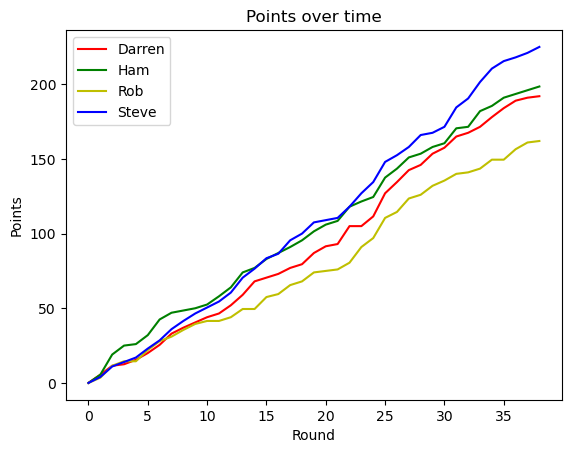

leader
steve                   22
ham                     14
darren/ham/rob/steve     1
darren/ham               1
ham/steve                1
Name: count, dtype: int64
loser
rob                     34
darren                   3
darren/ham/rob/steve     1
steve                    1
Name: count, dtype: int64


In [170]:

points_over_time = pd.DataFrame()
for player in sd.players:
    points_over_time[player] = df_round_collection[player]['Round points'].cumsum()

# Add zero to the beginning
points_over_time.loc[-1] = np.zeros(len(sd.players))
points_over_time.index = points_over_time.index + 1
points_over_time = points_over_time.sort_index()


# Who was leading and losing at each point
max_values = points_over_time.max(axis=1)
min_values = points_over_time.min(axis=1)

is_max = points_over_time.eq(max_values, axis=0)
is_min = points_over_time.eq(min_values, axis=0)

# Function to generate the new column values
def generate_new_col(row):
    max_columns = row[row].index.tolist()  # Get column names where the value is True
    return '/'.join(max_columns)

# Apply the function to each row to create the new column
points_over_time['leader'] = is_max.apply(generate_new_col, axis=1)
points_over_time['loser'] = is_min.apply(generate_new_col, axis=1)


fig, ax = plt.subplots()
for idx, player in enumerate(sd.players):
    ax.plot(points_over_time[player], label=player.capitalize(), c=sd.player_cols[idx])

ax.set_xlabel('Round')
ax.set_ylabel('Points')
ax.set_title('Points over time')
plt.legend()
plt.show()

print(points_over_time['leader'].value_counts())
print(points_over_time['loser'].value_counts())

### Who lost out in the last minutes of games?

In [192]:
match_records_raw = pd.read_json('./data/match_data_fixed.json')

In [194]:
def get_goal_times_df(matches):
    """
    Returns a dataframe similar to df_match_results, but with added columns for who scored the goals and when
    """
    columns = ['Date', 'Home team', 'Away team', 'Home goals', 'Away goals', 'Home scorers', 'Away scorers', 'Home goal times', 'Away goal times']
    match_data = pd.DataFrame(columns=columns)

    for idx, match in matches.iterrows():
        match_date = match['match']['date'] 
        homeName = match['match']['home-team']['name']
        homeScore = match['match']['home-team']['score']
        awayName = match['match']['away-team']['name']
        awayScore = match['match']['away-team']['score']
        homeScorers = ''
        awayScorers = ''
        homeGoalTimes = ''
        awayGoalTimes = ''

        if homeScore > 0:
            if 'goals' in match['match']['home-team'].keys():
                if len(match['match']['home-team']['goals']) == homeScore:
                    for goal in match['match']['home-team']['goals']:
                        player = goal['player']['first-name'] + ' ' + goal['player']['last-name']
                        time = goal['minute']
                        homeScorers += player + ','
                        homeGoalTimes += str(time) + ','
                else:
                    print('Diff number of goals from score (HOME): ' + str(idx))
            else:
                print('No goal info (HOME): ' + str(idx))

        if awayScore > 0:
            if 'goals' in match['match']['away-team'].keys():
                if len(match['match']['away-team']['goals']) == awayScore:
                    for goal in match['match']['away-team']['goals']:
                        player = goal['player']['first-name'] + ' ' + goal['player']['last-name']
                        time = goal['minute']
                        awayScorers += player + ','
                        awayGoalTimes += str(time) + ','
                else:
                    print('Diff number of goals from score (AWAY): ' + str(idx))
            else:
                print('No goal info (AWAY): ' + str(idx))

        vals = [[match_date], [homeName], [awayName], [homeScore], [awayScore], [homeScorers], [awayScorers], [homeGoalTimes], [awayGoalTimes]]

        match_data = pd.concat([match_data,pd.DataFrame(dict(zip(columns,vals)))], axis=0, ignore_index=True)
        match_data["Home team"] = match_data["Home team"].astype("category")
        match_data["Away team"] = match_data["Away team"].astype("category")

        name_map = {'Heart of Midlothian': 'Hearts', 'St Mirren': 'St. Mirren'}
        match_data["Home team"].replace(name_map,inplace=True)
        match_data["Away team"].replace(name_map,inplace=True)
        
    return match_data


match_data = get_goal_times_df(match_records_raw)

print(match_data.iloc[2])

matches_w_preds = pd.merge(df_predictions, match_data, how='left', on=['Home team', 'Away team', 'Home goals', 'Away goals'])

print(matches_w_preds.loc[matches_w_preds.isna().any(axis=1)])

Date                                                      2023-08-05
Home team                                                     Celtic
Away team                                                Ross County
Home goals                                                         4
Away goals                                                         2
Home scorers       David Turnbull,Kyogo Furuhashi,David Turnbull,...
Away scorers                               Jordan White,James Brown,
Home goal times                                         17,26,42,73,
Away goal times                                               59,90,
Name: 2, dtype: object
     Round    Home team Away team Home goals Away goals  Home prediction  \
245     38  Ross County  Aberdeen          2          2                0   

     Away prediction Player score  Home prediction_ham  Away prediction_ham  \
245                2       0WRONG                    0                    2   

     ... Player score_steve  Darren points  